In [1]:
!which python

/anaconda3/envs/nlp2/bin/python


In [2]:
import transformers
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

### Loading data

In [3]:
df = pd.read_csv('../train_data.csv', index_col=0)

In [4]:
df.head()

,features,categorical_target_1,categorical_target_2,continuous_target_1,continous_target_2
110018,"“Today, as in the past,” reads the title of th...",France,Sauvignon Blanc,92,28.0
14618,"Crisp, dry and searing in acidity, this 100% v...",US,Sauvignon Blanc,91,22.0
108512,"Light and lovely, this has just under 2% resid...",US,Riesling,90,10.0
129544,"Borra's blend of 80% Petite Sirah, 10% Syrah a...",US,Red Blend,89,35.0
85383,The spirit of South Africa's Swartland region ...,South Africa,Shiraz,87,19.0


In [6]:
df.columns = ['text', 'country', 'variety', 'points', 'price']

In [7]:
df.isnull().sum()

text          0
country      49
variety       1
points        0
price      7247
dtype: int64

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
text,103976,97529,"Seductively tart in lemon pith, cranberry and ...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,103927,43,US,43568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,103975,672,Pinot Noir,10593,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,103976,NaN,NaN,NaN,88.4527,3.03889,80,86,88,91,100
price,96729,NaN,NaN,NaN,35.4501,41.1206,4,17,25,42,2500


Notes about data:

- This is the wine dataset from Kaggle, with a subset of features only.

- There are duplicate text, suggesting that they are duplicate records because reviews should be unique and it is highly unlikely that we get exact same text match from two reviewers, unless it is a one or two words only, but we don't even have reviews with less than 3 words.

- High prices of wine were not considered outliers.

- Large number of missing values in the prices variable, I just dropped these data points as I will be using price as a target variable.

- Country missing values can be replaces with a new category "Unknown" but since it is a tiny fraction, I will just drop these rows for simplicity.


In [53]:
## Example of duplicate review
df[df.text.apply(lambda x: "Seductively tart in lemon pith, cranberry " in x)]

,text,country,variety,points,price,text_len
12141,"Seductively tart in lemon pith, cranberry and ...",US,Pinot Noir,91,29.0,42
119866,"Seductively tart in lemon pith, cranberry and ...",US,Pinot Noir,89,25.0,42
51822,"Seductively tart in lemon pith, cranberry and ...",US,Pinot Noir,89,25.0,42


### Dropping duplicates

In [9]:
df.drop_duplicates().shape

(97545, 5)

In [ ]:
## Visualising in

Text(0.5, 0, 'Country')

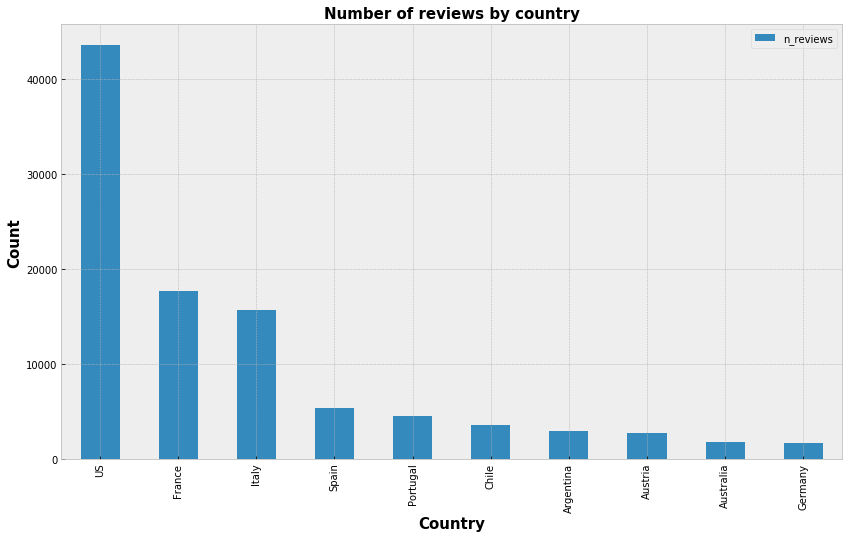

In [38]:
df.assign(n_reviews=1).groupby('country')[['n_reviews']].sum().sort_values('n_reviews', ascending=False)[:10].plot(kind='bar', figsize=(14,8))
plt.title('Number of reviews by country', fontsize= 15, fontweight='bold')
plt.ylabel('Count', fontsize= 15, fontweight='bold')
plt.xlabel('Country', fontsize= 15, fontweight='bold')

Text(0.5, 0, 'Country')

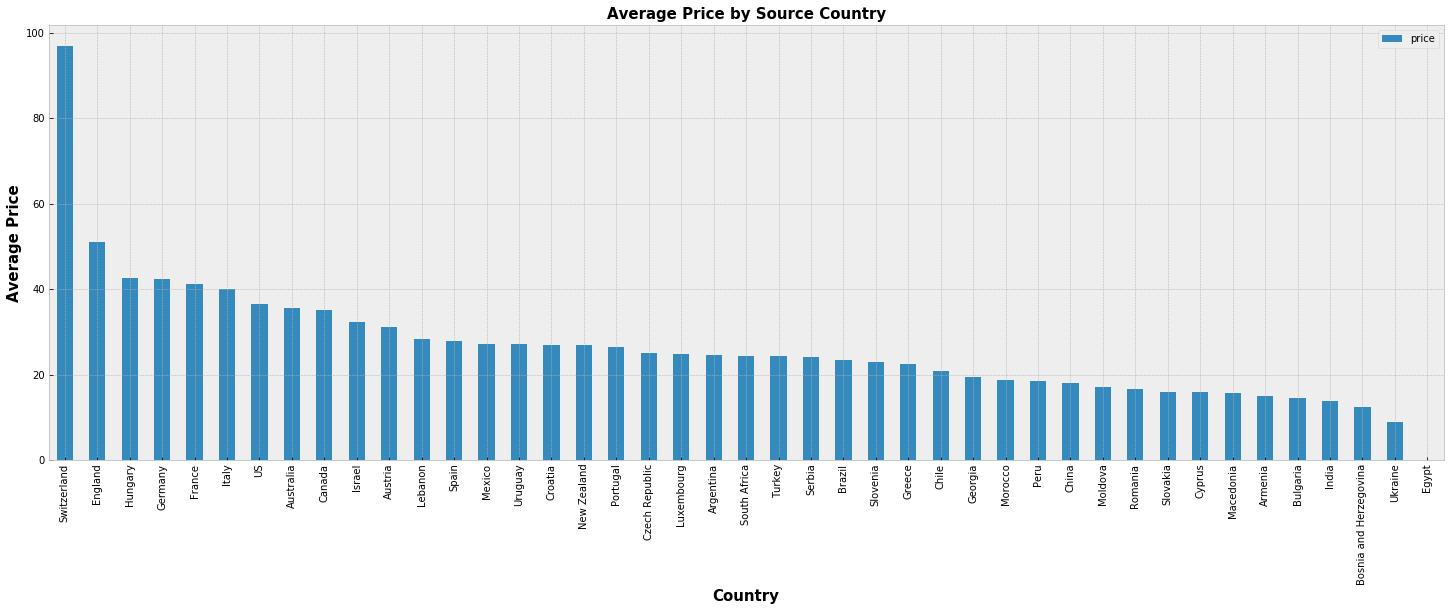

In [39]:
df.groupby('country')[['price']].mean().sort_values('price', ascending=False).plot(kind='bar', figsize=(25,8))
plt.title('Average Price by Source Country', fontsize= 15, fontweight='bold')
plt.ylabel('Average Price', fontsize= 15, fontweight='bold')
plt.xlabel('Country', fontsize= 15, fontweight='bold')

(80, 95)

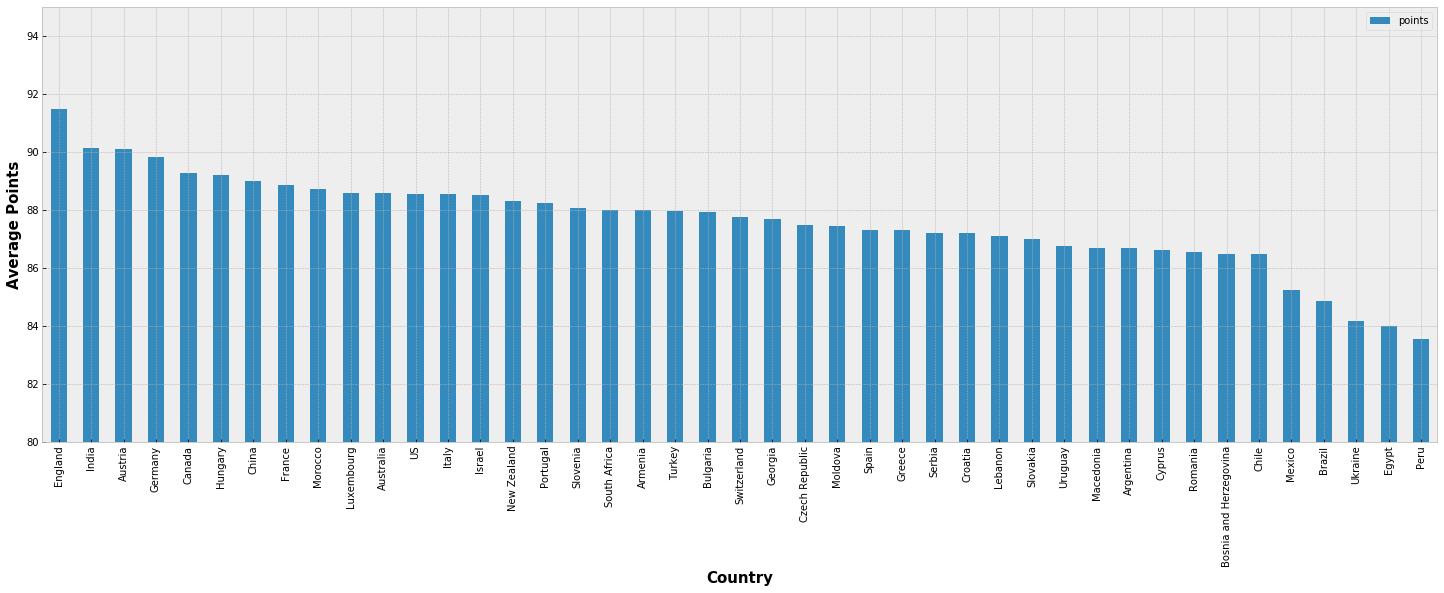

In [36]:
df.groupby('country')[['points']].mean().sort_values('points', ascending=False).plot(kind='bar', figsize=(25,8))
plt.ylabel('Average Points', fontsize= 15, fontweight='bold')
plt.xlabel('Country', fontsize= 15, fontweight='bold')
plt.ylim((80,95))

Text(0.5, 0, 'Points')

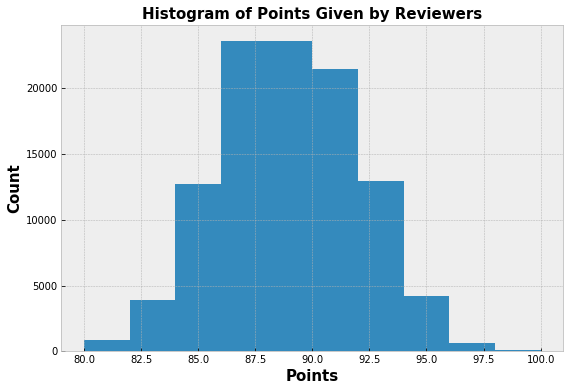

In [45]:
plt.figure(figsize=(9,6))
df.points.hist()
plt.title('Histogram of Points Given by Reviewers', fontsize= 15, fontweight='bold')
plt.ylabel('Count', fontsize= 15, fontweight='bold')
plt.xlabel('Points', fontsize= 15, fontweight='bold')

Text(0.5, 0, 'Price')

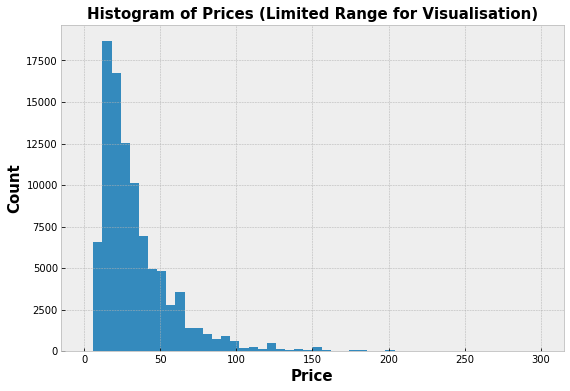

In [49]:
df.price.hist(bins=50, range=(0,300), figsize=(9,6))
plt.title('Histogram of Prices (Limited Range for Visualisation)', fontsize= 15, fontweight='bold')
plt.ylabel('Count', fontsize= 15, fontweight='bold')
plt.xlabel('Price', fontsize= 15, fontweight='bold')

Text(0.5, 0, 'Review Length')

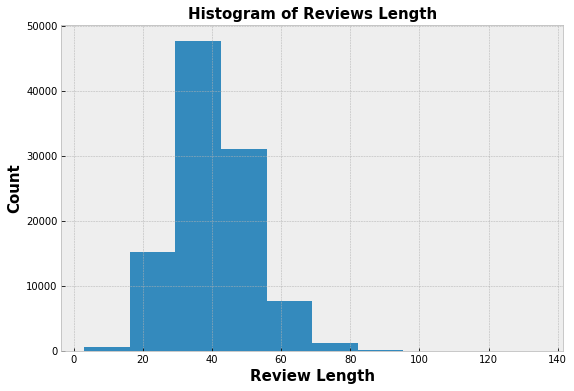

In [51]:
df['text_len'] = df.text.str.split().str.len()
df.text_len.hist(figsize=(9,6))
plt.title('Histogram of Reviews Length', fontsize= 15, fontweight='bold')
plt.ylabel('Count', fontsize= 15, fontweight='bold')
plt.xlabel('Review Length', fontsize= 15, fontweight='bold')

In [68]:
### For later stages, to get the text embedding, it will be useful to limit the number of words in reviews.
### For efficiency I will limit number of words to 100, as there are only few samples that exceeds that limit.
df[df.text_len>100].shape[0]

27

In [19]:
len_price_df = df.groupby('text_len')[['price']].mean().reset_index()

Text(0.5, 0, 'Review Length')

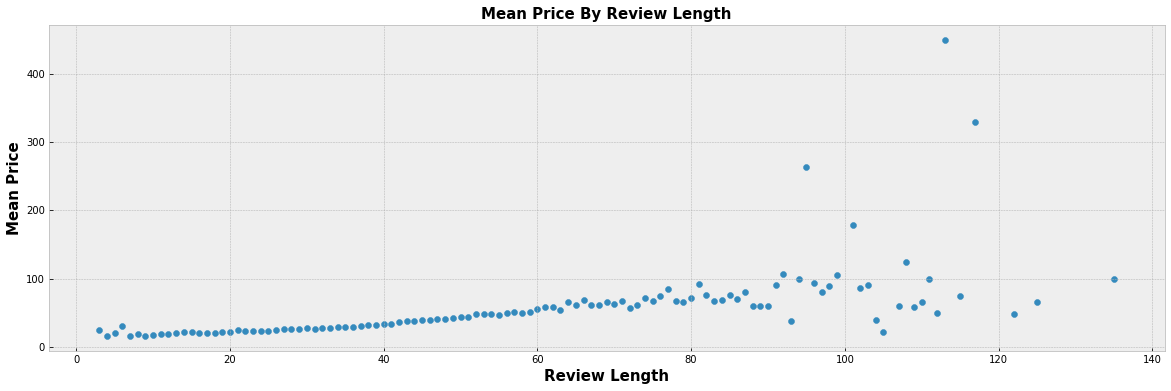

In [59]:
plt.figure(figsize=(20,6))
plt.scatter(len_price_df.text_len, len_price_df.price)

plt.title('Mean Price By Review Length', fontsize= 15, fontweight='bold')
plt.ylabel('Mean Price', fontsize= 15, fontweight='bold')
plt.xlabel('Review Length', fontsize= 15, fontweight='bold')

### Correlation between price and points

(0, 1000)

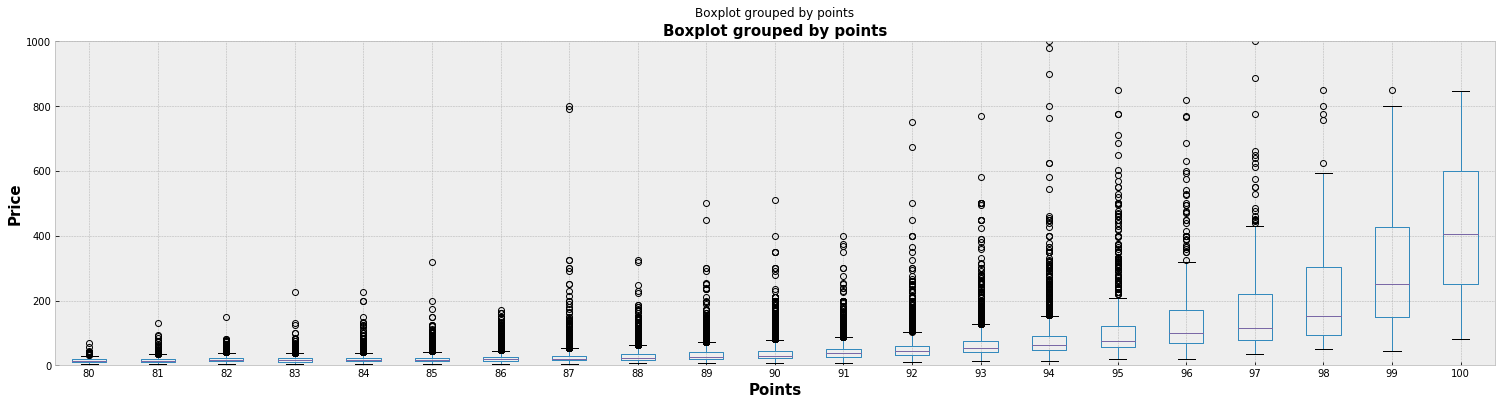

In [66]:
df.boxplot('price', by='points',figsize=(25,6))
plt.title('Boxplot grouped by points', fontsize= 15, fontweight='bold')
plt.ylabel('Price', fontsize= 15, fontweight='bold')
plt.xlabel('Points', fontsize= 15, fontweight='bold')
plt.ylim(0,1000)